In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import numpy as np
import string

from tensorflow.keras import layers
from tensorflow.keras import losses

In [ ]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

stopwords_dict = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
path = 'drive/MyDrive/dataset/multilabel_comment_dataset.csv'

dataset = pd.read_csv(path, encoding = 'utf8')

dataset.head()

,comment_text,harmful,severe,obscene,threat,insult,discriminate,normal
0,bangladeshi cyclists i notice you did a name c...,0,0,0,0,0,0,1
1,in the ass bitch fucking cock sucker,1,1,1,0,1,1,0
2,ur so immature frnziim and ur not evn debating...,1,0,1,0,1,1,0
3,hi goodday i have noted that qwyrxian has weig...,0,0,0,0,0,0,1
4,for fucks sake just fucking stop you spastic a...,1,1,1,0,1,0,0


In [ ]:
def remove_stopwords(text):
  words = [word for word in text.split() if word not in stopwords_dict]
  return " ".join(words)

dataset['comment_text'] = dataset['comment_text'].apply(remove_stopwords)

In [ ]:
raw_train, raw_validation, raw_test = np.split(dataset.sample(frac=1), [int(0.7*len(dataset)), int(0.9*len(dataset))])

print(len(raw_train), 'training examples')
print(len(raw_validation), 'validation examples')
print(len(raw_test), 'test examples')

def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df[['harmful', 'severe', 'obscene', 'threat', 'insult', 'discriminate', 'normal']].values
  df = df['comment_text']
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

raw_train_ds = df_to_dataset(raw_train)
raw_val_ds = df_to_dataset(raw_validation)
raw_test_ds = df_to_dataset(raw_test)

200652 training examples
57329 validation examples
28665 test examples


# Text Vectorization

The first layer of the model is **Text Vectorization** which converts the human string to number array. This is an preprocessing approach because neural network or even computer is not friendly with text but numeric data. There are some parameters that need to notice: **max_features** is vocabulary size of dataset (is restricted to 180,000), **sequence_length** defines the length of output (it will truncate the output to that length), the **output_mode='int'** cast the output array to an integer arr. Before using the layer, we adapt it with the train text so that the layer learns the vocabulary and dataset.

As the next step, we're passing all 3 datasets to the layer. The **vectorize_text** function will take 2 strings text and label, expanding the dimension of text tensor to match the expected input. In the last part, **cache(**) caches the dataset in memory to avoid bottlenecks and **prefetch** prefetches data for optimal performance, allowing for the autonamtic tuning of the buffer size.

In [47]:
max_features = 180000
sequence_length = 300

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    max_tokens=max_features,
    output_sequence_length=sequence_length,
    output_mode='int'
)

train_text = raw_train_ds.map(lambda text, labels: text)
vectorize_layer.adapt(train_text)

def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# CNN Model

In [49]:
# nums of character in a word
embedding_dim = 26

model = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(32, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(16, activation='relu'),
  layers.Dense(7, activation='sigmoid')
])

model.summary()

model.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 26)          4680000   
                                                                 
 dropout_12 (Dropout)        (None, None, 26)          0         
                                                                 
 global_average_pooling1d_6  (None, 26)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_13 (Dropout)        (None, 26)                0         
                                                                 
 dense_15 (Dense)            (None, 32)                864       
                                                                 
 dropout_14 (Dropout)        (None, 32)                0         
                                                      

In [50]:
epochs = 5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
196/196 [==============================] - 92s 461ms/step - loss: 0.6099 - binary_accuracy: 0.6815 - val_loss: 0.5725 - val_binary_accuracy: 0.6953
Epoch 2/5
196/196 [==============================] - 91s 461ms/step - loss: 0.5390 - binary_accuracy: 0.7296 - val_loss: 0.4352 - val_binary_accuracy: 0.8208
Epoch 3/5
196/196 [==============================] - 86s 441ms/step - loss: 0.3622 - binary_accuracy: 0.8489 - val_loss: 0.3053 - val_binary_accuracy: 0.8735
Epoch 4/5
196/196 [==============================] - 84s 430ms/step - loss: 0.2888 - binary_accuracy: 0.8759 - val_loss: 0.2678 - val_binary_accuracy: 0.8856
Epoch 5/5
196/196 [==============================] - 95s 483ms/step - loss: 0.2611 - binary_accuracy: 0.8865 - val_loss: 0.2490 - val_binary_accuracy: 0.8919


In [51]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

28/28 [==============================] - 2s 66ms/step - loss: 0.2480 - binary_accuracy: 0.8930
Loss:  0.2479616403579712
Accuracy:  0.8930054306983948


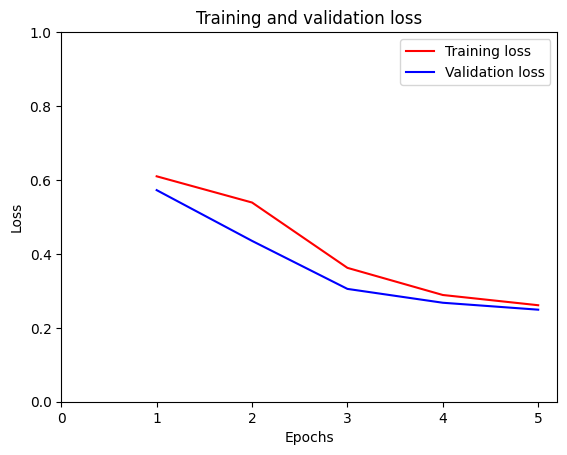

In [52]:
history_dict = history.history

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yticks(np.arange(0, 1.2, 0.2))
plt.xticks(np.arange(0, len(acc) + 1, 1))
plt.legend()

plt.show()

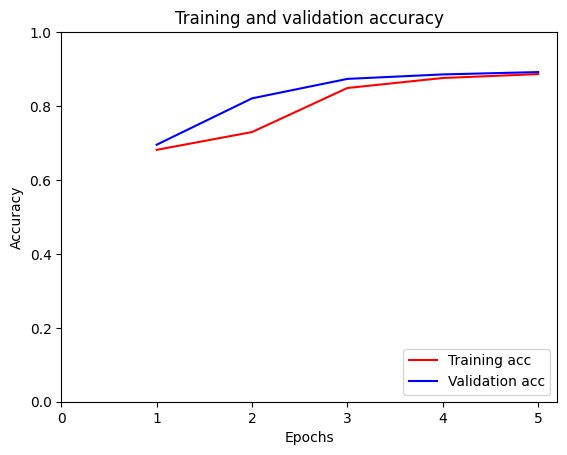

In [53]:
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.yticks(np.arange(0, 1.2, 0.2))
plt.xticks(np.arange(0, len(acc) + 1, 1))
plt.legend(loc='lower right')

plt.show()

In [54]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model
])

export_model.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

1/1 [==============================] - 0s 111ms/step
Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,


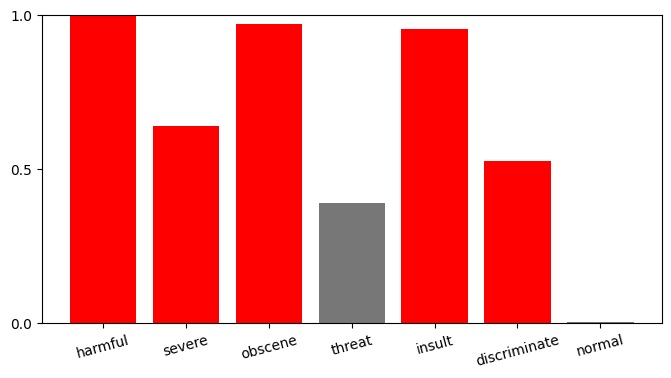

Dear god this site is horrible.


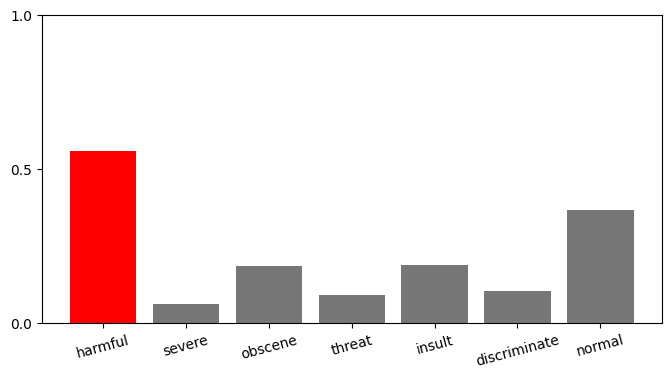

Only a fool can believe in such numbers.


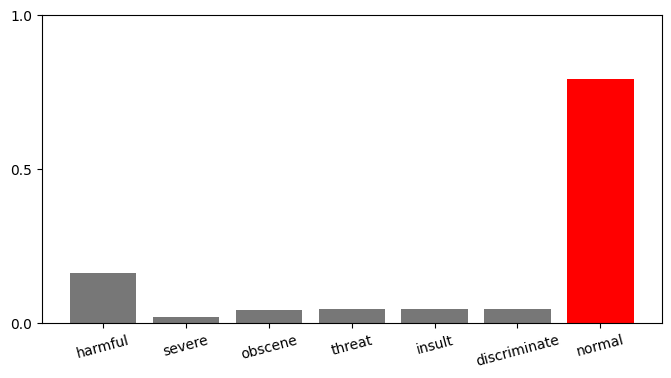

I have indefinitely blocked this account.


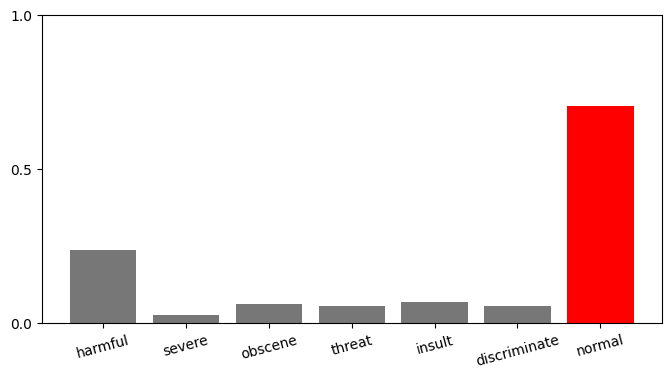

Please stop. If you continue to vandalize TikTok, as you did to Homosexuality, you will be blocked from editing.


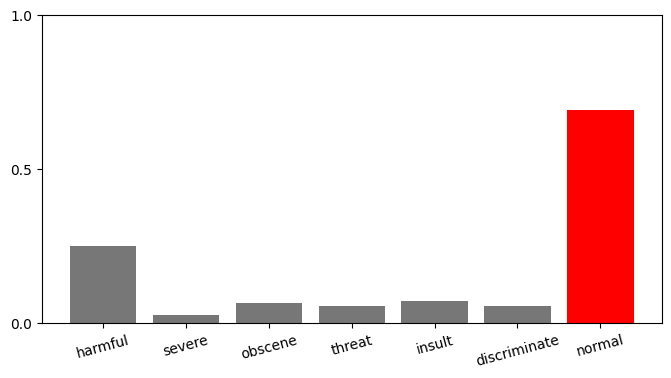

I've deleted the page , as we have no evidence that you are the person named on that page, and its content goes against Wikipedia's policies for the use of user pages.


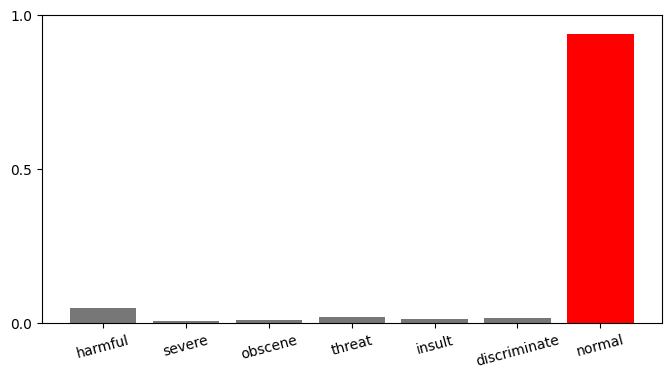

The word bitch is from the Old Norse Bikkjuna meaning female of the dog of unknown origin, Grimm derives the Old Norse words from Lapp Pittja, But OED notes that the converse is equally possible. 


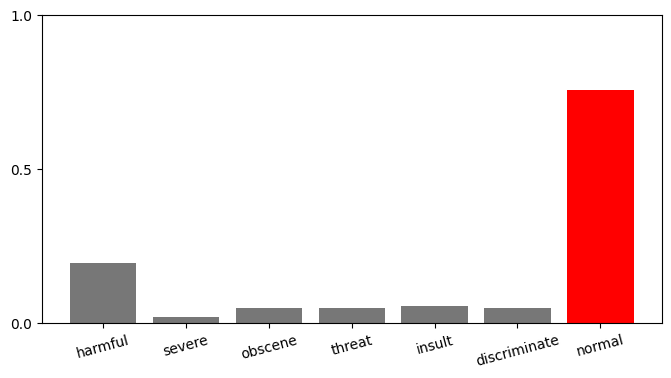

The adj. Bitchy was first seen in 1925.


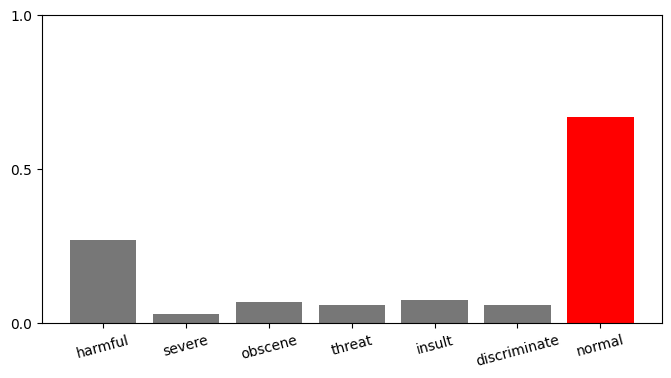

The word bitch is actually only offencive in American and Canadian English. In most other English variants bitch maintains it's correct definition - female canine. People have argued that bitch is different because it is used as an insult - but so is pig, dog, cow and others. These are not considered profane, so why is bitch? As far as I am concerned, there is nothing to reclaim as bitch simply means a female canine.


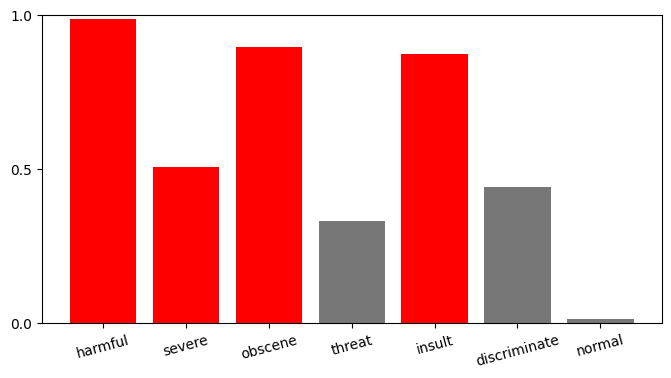

Hi... Bitch


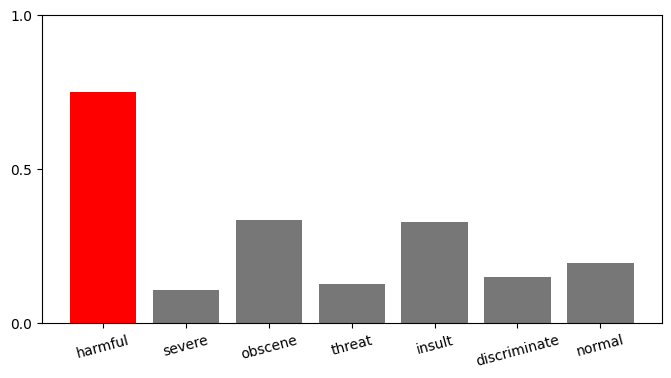

HIS DICK IS MIGHTY FINE!!!!!!!!!!


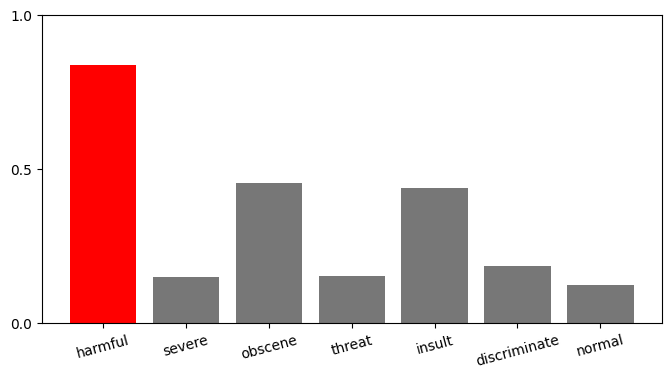

Discard All said previously... We love you Carlos... I LOVE YOU! I WANT TO RAPE YOU O Just Kidding


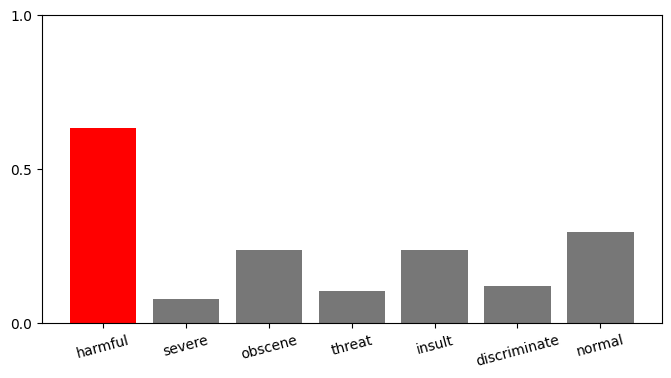

dffhdfdfghldfugdfhdiufhudifhgudighdfu fuck yo bfhiffbifbdufh wilvingstone simplice


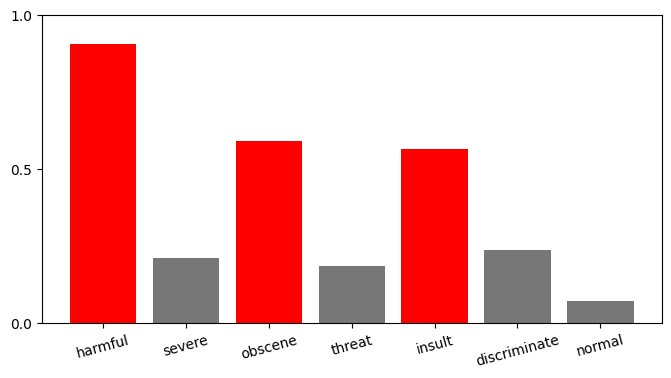

In [55]:
inputs = [
  "Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,",
  "Dear god this site is horrible.",
  "Only a fool can believe in such numbers.",
  "I have indefinitely blocked this account.",
  "Please stop. If you continue to vandalize TikTok, as you did to Homosexuality, you will be blocked from editing.",
  "I've deleted the page , as we have no evidence that you are the person named on that page, and its content goes against Wikipedia's policies for the use of user pages.",
  "The word bitch is from the Old Norse Bikkjuna meaning female of the dog of unknown origin, Grimm derives the Old Norse words from Lapp Pittja, But OED notes that the converse is equally possible. ",
  "The adj. Bitchy was first seen in 1925.",
  "The word bitch is actually only offencive in American and Canadian English. In most other English variants bitch maintains it's correct definition - female canine. People have argued that bitch is different because it is used as an insult - but so is pig, dog, cow and others. These are not considered profane, so why is bitch? As far as I am concerned, there is nothing to reclaim as bitch simply means a female canine.",
  "Hi... Bitch",
  "HIS DICK IS MIGHTY FINE!!!!!!!!!!",
  "Discard All said previously... We love you Carlos... I LOVE YOU! I WANT TO RAPE YOU O Just Kidding",
  "dffhdfdfghldfugdfhdiufhudifhgudighdfu fuck yo bfhiffbifbdufh wilvingstone simplice",
]

examples = tf.constant(inputs)
def plot_value_array(prediction):
  colors=["red" if pred >= 0.5 else "#777777" for pred in prediction]
  thisplot = plt.bar(range(len(prediction)), prediction, color=colors)
  plt.xticks(range(len(prediction)), ['harmful', 'severe', 'obscene', 'threat', 'insult', 'discriminate', 'normal'], rotation=15)
  plt.yticks([0, 0.5, 1])
  plt.ylim([0, 1])

predictions = export_model.predict(examples)

for i in range(len(inputs)):
  plt.figure(figsize=(8, 4))
  print(inputs[i])
  plot_value_array(predictions[i])
  plt.show()

In [40]:
max_tokens = 3  # Maximum vocab size.
max_len = 5  # Sequence length to pad the outputs to.
# Create the layer.
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=max_len)

vectorize_layer.adapt(["foo bar", "bar baz", "baz bada boom"])

input_data = [["foo qux bar"], ["qux baz"]]
vectorize_layer(input_data)

<tf.Tensor: shape=(2, 5), dtype=int64, numpy=
array([[1, 1, 1, 0, 0],
       [1, 2, 0, 0, 0]])>

In [41]:
vectorize_layer.get_vocabulary()

['', '[UNK]', 'baz']